In [111]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
import scipy.stats as stats
from scipy import stats
from scipy.stats import cauchy
import random
import sympy as sp
from scipy.optimize import fsolve
import matplotlib.patches as mpatches
from scipy.signal import find_peaks

In [112]:
N = 5
C = 1
c1 = 3
c2 = 0.3
VT = -20
sigma = 0.8


In [113]:
def I_L(V): 
    return gL * (V - EL)
def I_Na(V, h): 
    return gNa * (m_inf(V) ** 3) * h * (V - ENa)
def I_K(V, h): 
    return gK * ((0.75 * (1 - h)) ** 4) * (V - EK)
def I_T(V, r): 
    return gT * (p_inf(V) ** 2) * r * (V - ET)

In [114]:
gL = 0.05
gNa = 3
gK = 5
gT = 5
EL = -70
ENa = 50
EK = -90
ET = 0


In [115]:
def h_inf(V):
    return 1/(1+np.exp((V+41)/4))
def r_inf(V):
    return 1/(1+np.exp((V+84)/4))
def alpha_h(V):
    return 0.128*np.exp(-((V+46)/18))
def beta_h(V):
    return 4/(1+np.exp(-(V+23)/5))
def tau_h(V):
    return 1/(alpha_h(V)+beta_h(V))
def tau_r(V):
    return 28+np.exp(-(V+25)/10.5)
def m_inf(V):
    return 1/(1+np.exp(-(V+37)/7))
def p_inf(V):
    return 1/(1+np.exp(-(V+60)/6.2))

In [116]:
def ds_dt(V, s):
    return c1 * (1 - s) / (1 + np.exp(-(V - VT) / sigma)) - c2 * s

In [117]:
A_plus = A_minus = 2.0
tau_plus = tau_minus = 10.0
gmin = 0.0
gmax = 1.0
tc = 3

In [118]:
def stdp_update(g, delta_t):
    if 0 < delta_t < tc:
        return g + A_plus * (1 - g) * np.exp(-delta_t / tau_plus)
    elif -tc < delta_t <= 0:
        return g - A_minus * (g - gmin) * np.exp(delta_t / tau_minus)
    else:
        return g

In [119]:
def I_syn(Vi, sj, gj_to_i):
    return K * gj_to_i * sj * (Vi - Esyn)

In [120]:
I_stim = np.full(N, 5.0) # Homogeneous
I_stim = np.random.uniform(4.84, 5.16, size=N) # Heterogeneous

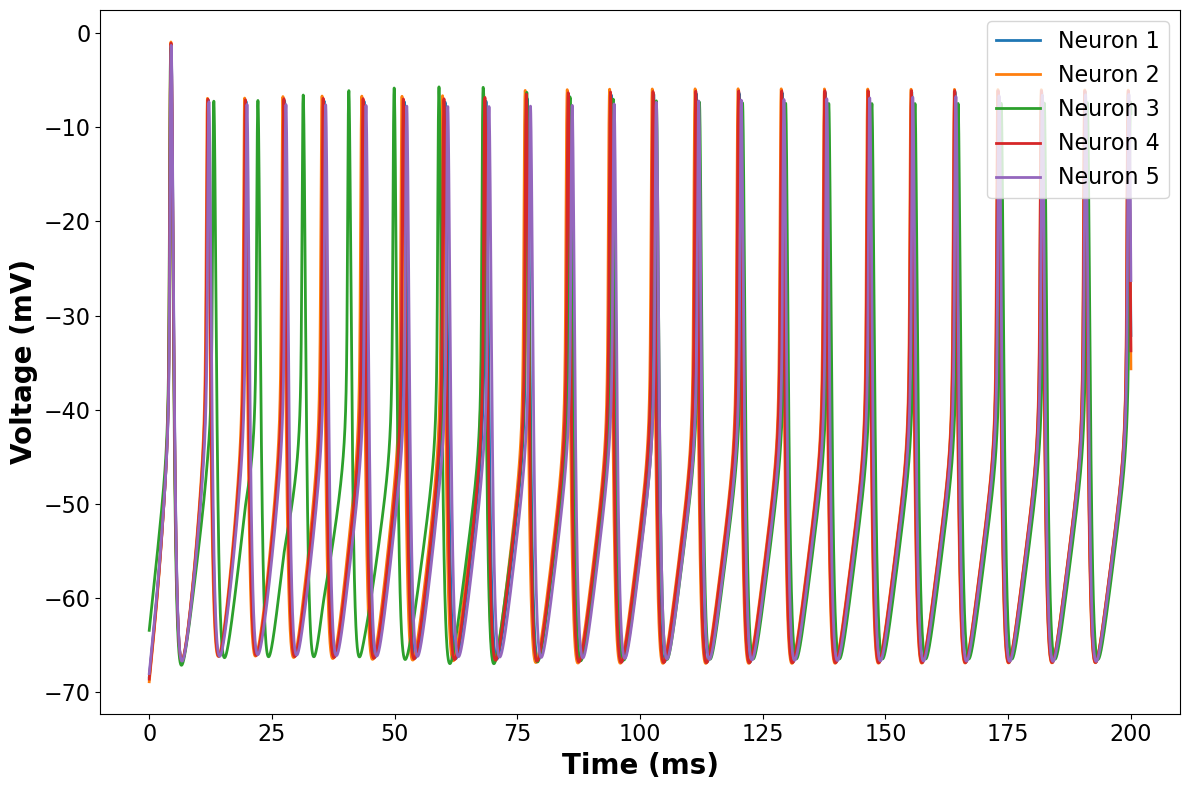

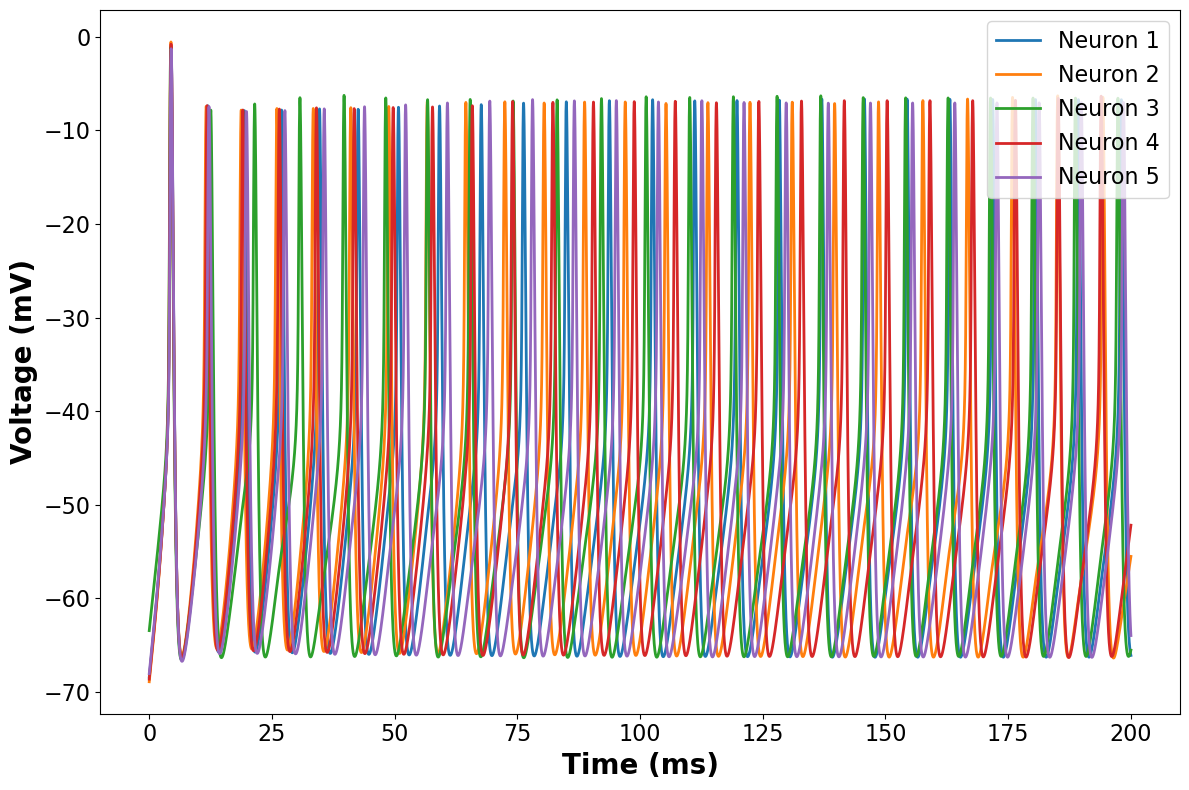

In [122]:
# ---------- Parameters ----------
N       = 5
C       = 1.0
Esyn    = -80.0
K       = 0.1               # global synaptic‐strength so that K·g_static = 0.1
gmin    = 0.0
gmax    = 1.0
A_plus  = A_minus  = 2.0
tau_plus= tau_minus = 10.0
tc      = 3.0               # STDP time window (ms)

t_total = 200.0
dt      = 0.001
t_eval  = np.arange(0, t_total, dt)

# ionic reversal potentials & conductances
EL, ENa, EK, ET = -70.0, 50.0, -90.0, 0.0
gL, gNa, gK, gT = 0.05, 3.0, 5.0, 5.0

# baseline currents (homogeneous here)
I_stim = np.full(N, 5.0)
#I_stim = np.random.uniform(4.84, 5.16, size=N) # Heterogeneous
# ---------- Gating & synapse kinetics ----------
def h_inf(V):    return 1/(1+np.exp((V+41)/4))
def r_inf(V):    return 1/(1+np.exp((V+84)/4))
def m_inf(V):    return 1/(1+np.exp(-(V+37)/7))
def p_inf(V):    return 1/(1+np.exp(-(V+60)/6.2))
def alpha_h(V):  return 0.128*np.exp(-(V+46)/18)
def beta_h(V):   return 4/(1+np.exp(-(V+23)/5))
def tau_h(V):    return 1/(alpha_h(V)+beta_h(V))
def tau_r(V):    return 28 + np.exp(-(V+25)/10.5)

def ds_dt(V, s, c1=3.0, c2=0.3, VT=-20.0, sigma=0.8):
    return c1*(1-s)/(1+np.exp(-(V-VT)/sigma)) - c2*s

# ionic currents
def I_L(V):     return gL*(V-EL)
def I_Na(V,h):  return gNa*(m_inf(V)**3)*h*(V-ENa)
def I_K(V,h):   return gK*((0.75*(1-h))**4)*(V-EK)
def I_T(V,r):   return gT*(p_inf(V)**2)*r*(V-ET)

# STDP update
def stdp_update(g, delta_t):
    if 0 < delta_t < tc:
        return np.clip(g + A_plus*(1-g)*np.exp(-delta_t/tau_plus), gmin, gmax)
    elif -tc < delta_t <= 0:
        return np.clip(g - A_minus*(g-gmin)*np.exp(delta_t/tau_minus), gmin, gmax)
    else:
        return g

# ---------- Full model RHS ----------
def full_model(t, y, g_matrix):
    V, h, r, s = np.split(y, 4)
    dV = np.zeros(N)
    dh = np.zeros(N)
    dr = np.zeros(N)
    ds = np.zeros(N)
    for i in range(N):
        Iion = I_L(V[i]) + I_Na(V[i],h[i]) + I_K(V[i],h[i]) + I_T(V[i],r[i])
        # note the K factor here:
        Isyn = K * sum(g_matrix[i,j]*s[j]*(V[i]-Esyn) for j in range(N) if j!=i)/(N-1)
        dV[i] = ( - Iion + I_stim[i] - Isyn )/C
        dh[i] = (h_inf(V[i]) - h[i]) / tau_h(V[i])
        dr[i] = (r_inf(V[i]) - r[i]) / tau_r(V[i])
        ds[i] = ds_dt(V[i], s[i])
    return np.concatenate([dV, dh, dr, ds])

# ---------- Initial conditions ----------
V0 = np.random.uniform(-70,-60, N)
h0 = h_inf(V0)
r0 = r_inf(V0)
s0 = np.zeros(N)
y0 = np.concatenate([V0,h0,r0,s0])

# ---------- 1) Static network (forward Euler for consistency) ----------
g_static = np.ones((N,N))
np.fill_diagonal(g_static, 0.0)

sol_static = np.zeros((4*N, len(t_eval)))
y = y0.copy()
sol_static[:,0] = y
for k,t in enumerate(t_eval[:-1]):
    dy = full_model(t, y, g_static)
    y  = y + dy*dt
    sol_static[:,k+1] = y

# ---------- 2) Plastic network (forward Euler + correct STDP) ----------
g_dynamic  = g_static.copy()      # start from same baseline
last_spikes= np.full(N, -1e6)     # far in the past
V_prev      = y0[:N].copy()

Y_stdp = np.zeros((4*N, len(t_eval)))
y = y0.copy()
Y_stdp[:,0] = y

for k,t in enumerate(t_eval[:-1]):
    dy = full_model(t, y, g_dynamic)
    y  = y + dy*dt

    V = y[:N]

    # threshold‐crossing with positive slope:
    for i in range(N):
        if V_prev[i] < -30 <= V[i] and (V[i]-V_prev[i])>0 and (t - last_spikes[i])>tc:
            # neuron i has just spiked
            for j in range(N):
                if i==j: continue
                # 1) update synapse j -> i  (post = i, pre = j)
                dt_ji = t - last_spikes[j]
                g_dynamic[i,j] = stdp_update(g_dynamic[i,j], dt_ji)
                # 2) update synapse i -> j  (post = j, pre = i)
                dt_ij = last_spikes[j] - t
                g_dynamic[j,i] = stdp_update(g_dynamic[j,i], dt_ij)
            last_spikes[i] = t

    V_prev = V.copy()
    Y_stdp[:,k+1] = y

# ---------- Plotting ----------
plt.figure(figsize=(12,8))
for i in range(N):
    plt.plot(t_eval, sol_static[i,:], label=f'Neuron {i+1}', linewidth=2)
#plt.title("Without Synaptic Plasticity", fontsize=20, fontweight='bold')
plt.xlabel("Time (ms)", fontsize=20, fontweight='bold')
plt.ylabel("Voltage (mV)", fontsize=20, fontweight='bold')
plt.legend(fontsize=16, loc='upper right')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('WithoutSTDPInhibitory.png')
plt.show()

plt.figure(figsize=(12,8))
for i in range(N):
    plt.plot(t_eval, Y_stdp[i,:], label=f'Neuron {i+1}', linewidth=2)
#plt.title("With Synaptic Plasticity", fontsize=20, fontweight='bold')
plt.xlabel("Time (ms)", fontsize=20, fontweight='bold')
plt.ylabel("Voltage (mV)", fontsize=20, fontweight='bold')
plt.legend(fontsize=16, loc='upper right')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('WithSTDPInhibitory.png')
plt.show()


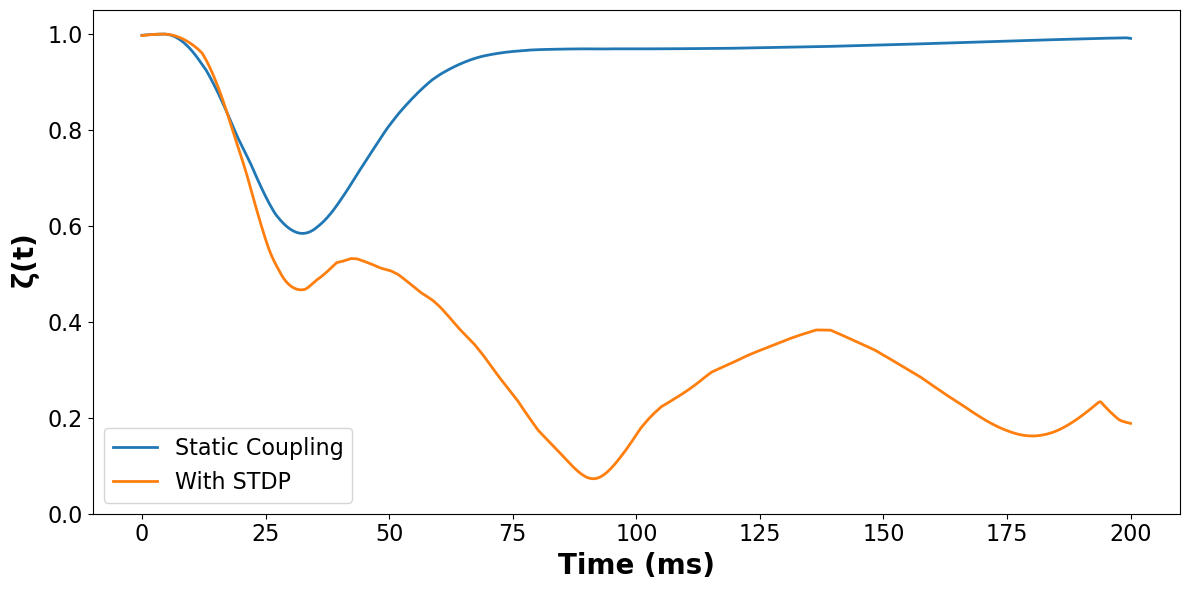

In [123]:
def compute_phases_and_R(V_traces, t_eval, thresh=-30.0):
    """
    V_traces: array (N, T) of voltages over time
    t_eval:    array (T,) of timepoints
    returns:   phases (N,T), R (T,)
    """
    N, T = V_traces.shape
    phases = np.zeros((N, T))
    
    # 1) detect spike times and mean ISI per neuron
    spike_times = []
    mean_ISI     = np.zeros(N)
    for i in range(N):
        # rising threshold crossings
        idx = np.where((V_traces[i,:-1] < thresh) & (V_traces[i,1:] >= thresh))[0]
        st = t_eval[idx]
        spike_times.append(st)
        if len(st) > 1:
            mean_ISI[i] = np.mean(np.diff(st))
        else:
            mean_ISI[i] = t_eval[-1]  # fallback if only 1 spike

    # 2) build a continuous phase by linear interpolation across an extended spike train
    for i in range(N):
        st = spike_times[i]
        isi = mean_ISI[i]
        # pad beginning and end so we cover [0, t_total]
        ext = np.concatenate(([st[0]-isi], st, [st[-1]+isi]))
        for k in range(len(ext)-1):
            t0, t1 = ext[k], ext[k+1]
            mask = (t_eval >= t0) & (t_eval < t1)
            phases[i,mask] = 2*np.pi * (t_eval[mask] - t0) / (t1 - t0)

    # 3) compute R(t)
    R = np.abs(np.sum(np.exp(1j * phases), axis=0) / N)
    return phases, R

# Extract voltage traces (rows 0..N-1 of your solution arrays)
V_static = sol_static[:N, :]   # shape (N, len(t_eval))
V_stdp   = Y_stdp[:N,   :]

# Compute phases and R
_, R_static = compute_phases_and_R(V_static, t_eval)
_, R_stdp   = compute_phases_and_R(V_stdp,   t_eval)

# 4) plot
plt.figure(figsize=(12,6))
plt.plot(t_eval, R_static, label='Static Coupling', linewidth=2)
plt.plot(t_eval, R_stdp,   label='With STDP',     linewidth=2)
plt.xlabel("Time (ms)",           fontsize=20, fontweight = 'bold')
plt.ylabel(r"$\mathbf{\zeta(t)}$",     fontsize=20, fontweight = 'bold')
plt.ylim(0, 1.05)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('KuramatoInhib.png')
plt.show()


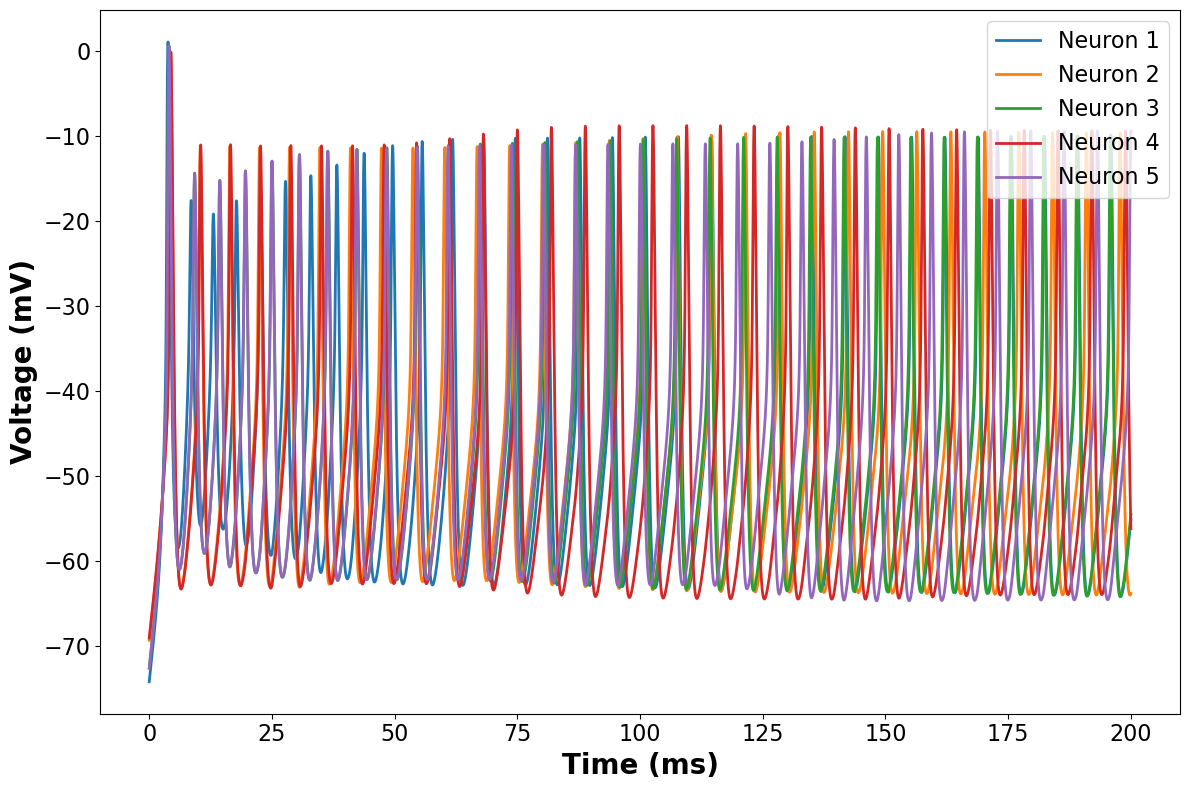

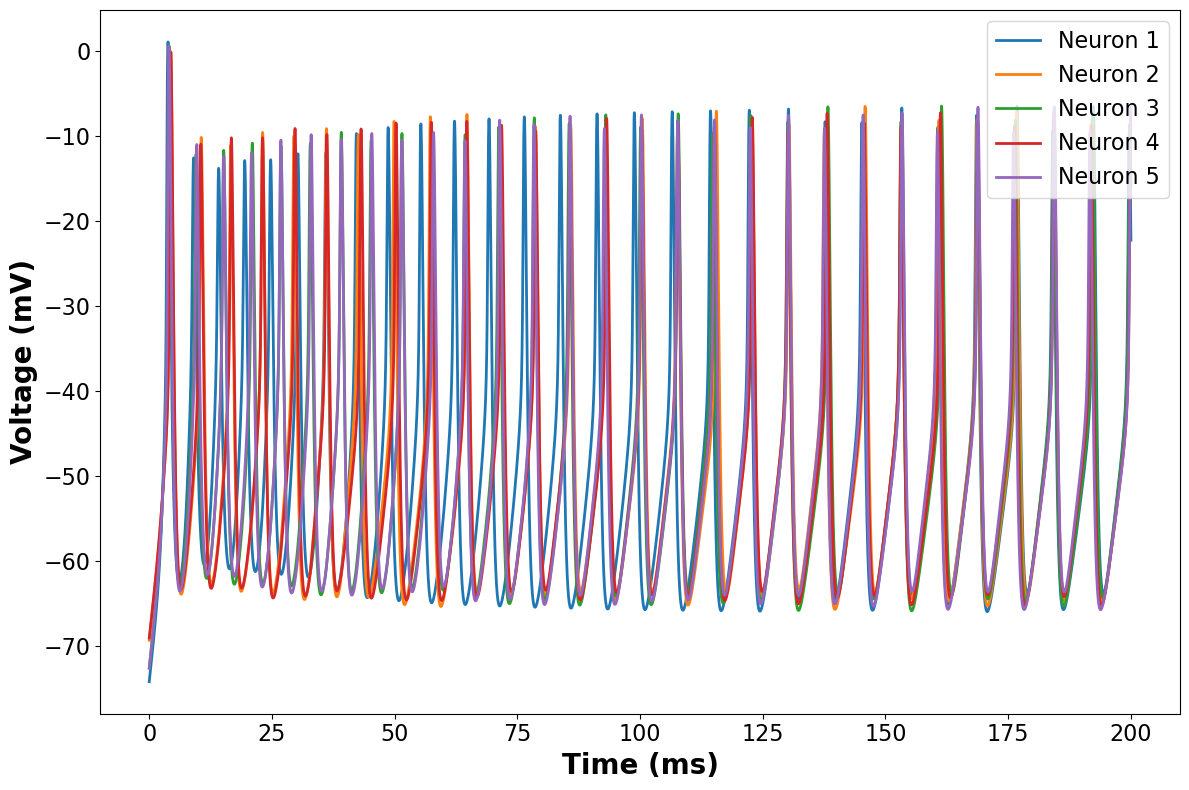

In [127]:
# ---------- Parameters ----------
N       = 5
C       = 1.0
Esyn    = 0
K       = 0.1               # global synaptic‐strength so that K·g_static = 0.1
gmin    = 0.0
gmax    = 1.0
A_plus  = A_minus  = 2.0
tau_plus= tau_minus = 10.0
tc      = 3.0               # STDP time window (ms)

t_total = 200.0
dt      = 0.001
t_eval  = np.arange(0, t_total, dt)

# ionic reversal potentials & conductances
EL, ENa, EK, ET = -70.0, 50.0, -90.0, 0.0
gL, gNa, gK, gT = 0.05, 3.0, 5.0, 5.0

# baseline currents (homogeneous here)
I_stim = np.full(N, 5.0)
#I_stim = np.random.uniform(4.84, 5.16, size=N) # Heterogeneous
# ---------- Gating & synapse kinetics ----------
def h_inf(V):    return 1/(1+np.exp((V+41)/4))
def r_inf(V):    return 1/(1+np.exp((V+84)/4))
def m_inf(V):    return 1/(1+np.exp(-(V+37)/7))
def p_inf(V):    return 1/(1+np.exp(-(V+60)/6.2))
def alpha_h(V):  return 0.128*np.exp(-(V+46)/18)
def beta_h(V):   return 4/(1+np.exp(-(V+23)/5))
def tau_h(V):    return 1/(alpha_h(V)+beta_h(V))
def tau_r(V):    return 28 + np.exp(-(V+25)/10.5)

def ds_dt(V, s, c1=3.0, c2=0.3, VT=-20.0, sigma=0.8):
    return c1*(1-s)/(1+np.exp(-(V-VT)/sigma)) - c2*s

# ionic currents
def I_L(V):     return gL*(V-EL)
def I_Na(V,h):  return gNa*(m_inf(V)**3)*h*(V-ENa)
def I_K(V,h):   return gK*((0.75*(1-h))**4)*(V-EK)
def I_T(V,r):   return gT*(p_inf(V)**2)*r*(V-ET)

# STDP update
def stdp_update(g, delta_t):
    if 0 < delta_t < tc:
        return np.clip(g + A_plus*(1-g)*np.exp(-delta_t/tau_plus), gmin, gmax)
    elif -tc < delta_t <= 0:
        return np.clip(g - A_minus*(g-gmin)*np.exp(delta_t/tau_minus), gmin, gmax)
    else:
        return g

# ---------- Full model RHS ----------
def full_model(t, y, g_matrix):
    V, h, r, s = np.split(y, 4)
    dV = np.zeros(N)
    dh = np.zeros(N)
    dr = np.zeros(N)
    ds = np.zeros(N)
    for i in range(N):
        Iion = I_L(V[i]) + I_Na(V[i],h[i]) + I_K(V[i],h[i]) + I_T(V[i],r[i])
        # note the K factor here:
        Isyn = K * sum(g_matrix[i,j]*s[j]*(V[i]-Esyn) for j in range(N) if j!=i)/(N-1)
        dV[i] = ( - Iion + I_stim[i] - Isyn )/C
        dh[i] = (h_inf(V[i]) - h[i]) / tau_h(V[i])
        dr[i] = (r_inf(V[i]) - r[i]) / tau_r(V[i])
        ds[i] = ds_dt(V[i], s[i])
    return np.concatenate([dV, dh, dr, ds])

# ---------- Initial conditions ----------
V0 = np.random.uniform(-75,-55, N)
h0 = h_inf(V0)
r0 = r_inf(V0)
s0 = np.zeros(N)
y0 = np.concatenate([V0,h0,r0,s0])

# ---------- 1) Static network (forward Euler for consistency) ----------
g_static = np.ones((N,N))
np.fill_diagonal(g_static, 0.0)

sol_static = np.zeros((4*N, len(t_eval)))
y = y0.copy()
sol_static[:,0] = y
for k,t in enumerate(t_eval[:-1]):
    dy = full_model(t, y, g_static)
    y  = y + dy*dt
    sol_static[:,k+1] = y

# ---------- 2) Plastic network (forward Euler + correct STDP) ----------
g_dynamic  = g_static.copy()      # start from same baseline
last_spikes= np.full(N, -1e6)     # far in the past
V_prev      = y0[:N].copy()

Y_stdp = np.zeros((4*N, len(t_eval)))
y = y0.copy()
Y_stdp[:,0] = y

for k,t in enumerate(t_eval[:-1]):
    dy = full_model(t, y, g_dynamic)
    y  = y + dy*dt

    V = y[:N]

    # threshold‐crossing with positive slope:
    for i in range(N):
        if V_prev[i] < -30 <= V[i] and (V[i]-V_prev[i])>0 and (t - last_spikes[i])>tc:
            # neuron i has just spiked
            for j in range(N):
                if i==j: continue
                # 1) update synapse j -> i  (post = i, pre = j)
                dt_ji = t - last_spikes[j]
                g_dynamic[i,j] = stdp_update(g_dynamic[i,j], dt_ji)
                # 2) update synapse i -> j  (post = j, pre = i)
                dt_ij = last_spikes[j] - t
                g_dynamic[j,i] = stdp_update(g_dynamic[j,i], dt_ij)
            last_spikes[i] = t

    V_prev = V.copy()
    Y_stdp[:,k+1] = y

# ---------- Plotting ----------
plt.figure(figsize=(12,8))
for i in range(N):
    plt.plot(t_eval, sol_static[i,:], label=f'Neuron {i+1}', linewidth=2)
#plt.title("Without Synaptic Plasticity", fontsize=20, fontweight='bold')
plt.xlabel("Time (ms)", fontsize=20, fontweight='bold')
plt.ylabel("Voltage (mV)", fontsize=20, fontweight='bold')
plt.legend(fontsize=16, loc='upper right')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('WithoutSTDPExcitatory.png')
plt.show()

plt.figure(figsize=(12,8))
for i in range(N):
    plt.plot(t_eval, Y_stdp[i,:], label=f'Neuron {i+1}', linewidth=2)
#plt.title("With Synaptic Plasticity", fontsize=20, fontweight='bold')
plt.xlabel("Time (ms)", fontsize=20, fontweight='bold')
plt.ylabel("Voltage (mV)", fontsize=20, fontweight='bold')
plt.legend(fontsize=16, loc='upper right')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('WithSTDPExcitatory.png')
plt.show()


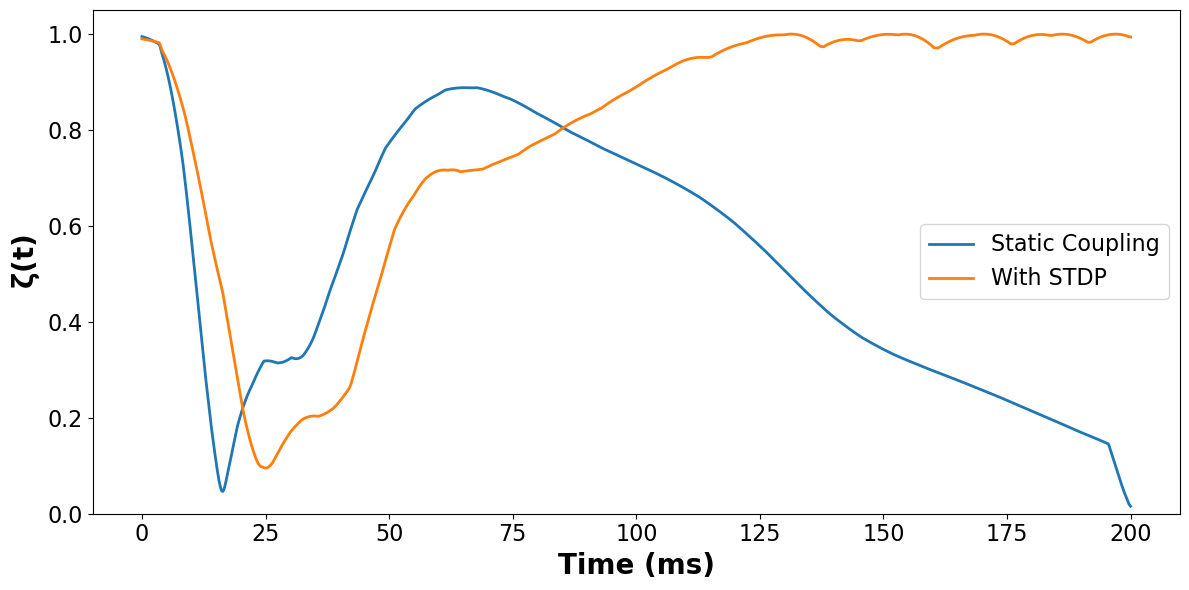

In [128]:
def compute_phases_and_R(V_traces, t_eval, thresh=-30.0):
    """
    V_traces: array (N, T) of voltages over time
    t_eval:    array (T,) of timepoints
    returns:   phases (N,T), R (T,)
    """
    N, T = V_traces.shape
    phases = np.zeros((N, T))
    
    # 1) detect spike times and mean ISI per neuron
    spike_times = []
    mean_ISI     = np.zeros(N)
    for i in range(N):
        # rising threshold crossings
        idx = np.where((V_traces[i,:-1] < thresh) & (V_traces[i,1:] >= thresh))[0]
        st = t_eval[idx]
        spike_times.append(st)
        if len(st) > 1:
            mean_ISI[i] = np.mean(np.diff(st))
        else:
            mean_ISI[i] = t_eval[-1]  # fallback if only 1 spike

    # 2) build a continuous phase by linear interpolation across an extended spike train
    for i in range(N):
        st = spike_times[i]
        isi = mean_ISI[i]
        # pad beginning and end so we cover [0, t_total]
        ext = np.concatenate(([st[0]-isi], st, [st[-1]+isi]))
        for k in range(len(ext)-1):
            t0, t1 = ext[k], ext[k+1]
            mask = (t_eval >= t0) & (t_eval < t1)
            phases[i,mask] = 2*np.pi * (t_eval[mask] - t0) / (t1 - t0)

    # 3) compute R(t)
    R = np.abs(np.sum(np.exp(1j * phases), axis=0) / N)
    return phases, R

# Extract voltage traces (rows 0..N-1 of your solution arrays)
V_static = sol_static[:N, :]   # shape (N, len(t_eval))
V_stdp   = Y_stdp[:N,   :]

# Compute phases and R
_, R_static = compute_phases_and_R(V_static, t_eval)
_, R_stdp   = compute_phases_and_R(V_stdp,   t_eval)

# 4) plot
plt.figure(figsize=(12,6))
plt.plot(t_eval, R_static, label='Static Coupling', linewidth=2)
plt.plot(t_eval, R_stdp,   label='With STDP',     linewidth=2)
plt.xlabel("Time (ms)",           fontsize=20, fontweight = 'bold')
plt.ylabel(r"$\mathbf{\zeta(t)}$",     fontsize=20, fontweight = 'bold')
plt.ylim(0, 1.05)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('KuramatoExcit.png')
plt.show()


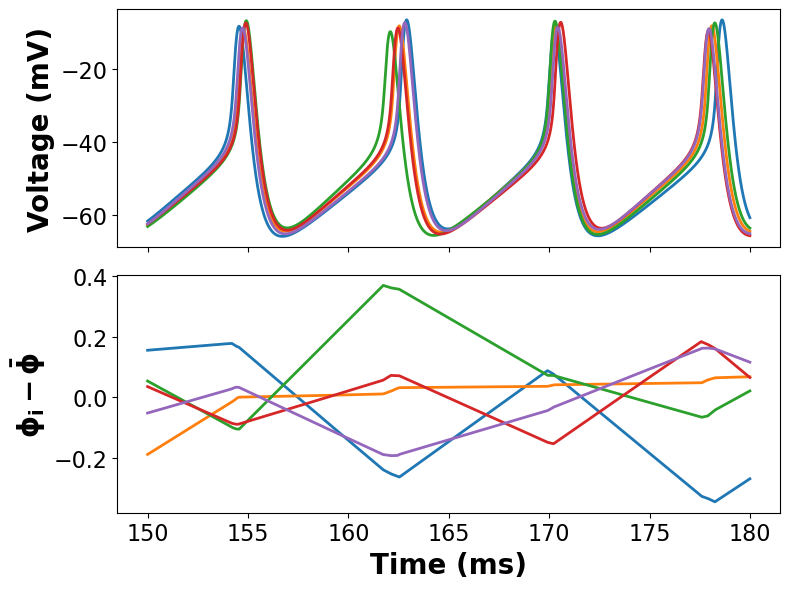

In [129]:
# ---------- Network and simulation parameters ----------
N       = 5
C       = 1.0
Esyn    = 0.0
K       = 0.1
gmin    = 0.0
gmax    = 1.0
A_plus  = A_minus  = 2.0
tau_plus= tau_minus = 10.0
tc      = 3.0               # STDP window (ms)

t_total = 200.0
dt      = 0.001
t_eval  = np.arange(0, t_total, dt)

# Reversal potentials & conductances
EL, ENa, EK, ET = -70.0, 50.0, -90.0, 0.0
gL, gNa, gK, gT = 0.05, 3.0, 5.0, 5.0

# Baseline current
I_stim = np.full(N, 5.0)

# ---------- Gating and synapse kinetics ----------
def h_inf(V):    return 1/(1+np.exp((V+41)/4))
def r_inf(V):    return 1/(1+np.exp((V+84)/4))
def m_inf(V):    return 1/(1+np.exp(-(V+37)/7))
def p_inf(V):    return 1/(1+np.exp(-(V+60)/6.2))
def alpha_h(V):  return 0.128*np.exp(-(V+46)/18)
def beta_h(V):   return 4/(1+np.exp(-(V+23)/5))
def tau_h(V):    return 1/(alpha_h(V)+beta_h(V))
def tau_r(V):    return 28 + np.exp(-(V+25)/10.5)

def ds_dt(V, s, c1=3.0, c2=0.3, VT=-20.0, sigma=0.8):
    return c1*(1-s)/(1+np.exp(-(V-VT)/sigma)) - c2*s

# Ionic currents
def I_L(V):     return gL*(V-EL)
def I_Na(V,h):  return gNa*(m_inf(V)**3)*h*(V-ENa)
def I_K(V,h):   return gK*((0.75*(1-h))**4)*(V-EK)
def I_T(V,r):   return gT*(p_inf(V)**2)*r*(V-ET)

# STDP update rule
def stdp_update(g, delta_t):
    if 0 < delta_t < tc:
        return np.clip(g + A_plus*(1-g)*np.exp(-delta_t/tau_plus), gmin, gmax)
    elif -tc < delta_t <= 0:
        return np.clip(g - A_minus*(g-gmin)*np.exp(delta_t/tau_minus), gmin, gmax)
    else:
        return g

# ---------- Full model RHS ----------
def full_model(t, y, g_matrix):
    V, h, r, s = np.split(y, 4)
    dV = np.zeros(N)
    dh = np.zeros(N)
    dr = np.zeros(N)
    ds = np.zeros(N)
    for i in range(N):
        Iion = I_L(V[i]) + I_Na(V[i],h[i]) + I_K(V[i],h[i]) + I_T(V[i],r[i])
        Isyn = K * sum(g_matrix[i,j]*s[j]*(V[i]-Esyn) for j in range(N) if j!=i)/(N-1)
        dV[i] = ( - Iion + I_stim[i] - Isyn )/C
        dh[i] = (h_inf(V[i]) - h[i]) / tau_h(V[i])
        dr[i] = (r_inf(V[i]) - r[i]) / tau_r(V[i])
        ds[i] = ds_dt(V[i], s[i])
    return np.concatenate([dV, dh, dr, ds])

# ---------- Initial conditions ----------
V0 = np.random.uniform(-75, -55, N)
h0 = h_inf(V0)
r0 = r_inf(V0)
s0 = np.zeros(N)
y0 = np.concatenate([V0, h0, r0, s0])

# ---------- Plastic network simulation ----------
g_dynamic   = np.ones((N,N))
np.fill_diagonal(g_dynamic, 0.0)
last_spikes = np.full(N, -1e6)
V_prev      = y0[:N].copy()

Y_stdp = np.zeros((4*N, len(t_eval)))
y = y0.copy()
Y_stdp[:,0] = y

for k, t in enumerate(t_eval[:-1]):
    dy = full_model(t, y, g_dynamic)
    y  = y + dy*dt
    V  = y[:N]

    # STDP on upward threshold crossings
    for i in range(N):
        if V_prev[i] < -30 <= V[i] and (t - last_spikes[i]) > tc:
            for j in range(N):
                if i == j: continue
                dt_ji = t - last_spikes[j]
                g_dynamic[i,j] = stdp_update(g_dynamic[i,j], dt_ji)
                dt_ij = last_spikes[j] - t
                g_dynamic[j,i] = stdp_update(g_dynamic[j,i], dt_ij)
            last_spikes[i] = t

    V_prev = V.copy()
    Y_stdp[:,k+1] = y

# ---------- Phase extraction ----------
phi = np.zeros((N, len(t_eval)))
for i in range(N):
    crosses = np.where((Y_stdp[i,:-1] < -30) & (Y_stdp[i,1:] >= -30))[0] + 1
    times   = t_eval[crosses]
    for j in range(len(times)-1):
        t0, t1 = times[j], times[j+1]
        idxs = np.where((t_eval >= t0) & (t_eval < t1))[0]
        phi[i, idxs] = 2*np.pi * (t_eval[idxs] - t0) / (t1 - t0)
    # extend last segment
    if len(times) > 1:
        period = times[-1] - times[-2]
        idxs = np.where(t_eval >= times[-1])[0]
        phi[i, idxs] = 2*np.pi * (t_eval[idxs] - times[-1]) / period

# Center around mean phase
phi_bar = np.angle(np.mean(np.exp(1j*phi), axis=0))
phi_dev = np.angle(np.exp(1j*(phi - phi_bar)))


# ---------- Plot 150–180 ms window ----------
start = int(150/dt); end = int(180/dt)
t_win = t_eval[start:end]
V_win = Y_stdp[:N, start:end]
phi_win = phi_dev[:, start:end]

fig, axes = plt.subplots(2,1, figsize=(8,6), sharex=True)
colors = plt.cm.tab10(np.arange(N))

for i in range(N):
    axes[0].plot(t_win, V_win[i], color=colors[i], lw=2)
axes[0].set_ylabel("Voltage (mV)", fontweight = 'bold', fontsize = '20')
axes[0].tick_params(axis='both', labelsize=16)
#axes[0].set_title("Full order model (150–180 ms)")

for i in range(N):
    axes[1].plot(t_win, phi_win[i], color=colors[i], lw=2)
axes[1].set_xlabel("Time (ms)", fontweight = 'bold', fontsize = '20')
axes[1].set_ylabel(r"$\mathbf{\phi_i - \bar\phi}$", fontsize = '20')
axes[1].tick_params(axis='both', labelsize=16)
#axes[1].set_title("Phase reduced model (150–180 ms)")

plt.tight_layout()
plt.tight_layout()
fig.savefig('voltage_phase.png')
plt.show()
plt.show()
